# Lab 9

### <span style="color:chocolate"> Submission requirements </span>

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Be sure your submitted notebook includes the output of your run (Hint: go to Kernel -> Restart Kernel and Run All Cells...)
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

In this lab, we'll train models for sentiment classification and experiment with learned embeddings for text features.

In [35]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.datasets import imdb

## Data for Sentiment Classification

In this lab, we'll train a *sentiment* classifier for movie reviews. That is, the input is the text of a movie review and the output is the probability the input was a positive review. The target labels are binary, 0 for negative and 1 for positive.

Our data includes 50,000 movie reviews on IMDB. The data comes pre-segmented into train and test splits. The [data loading function](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) below also splits each input text into tokens (words) and maps the words to integer values. Each input is a sequence of integers corresponding to the words.

In [2]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

print('First training example data:', X_train[0])
print('First training example label:', Y_train[0])

X_train.shape: (25000,)
Y_train.shape: (25000,)
X_test.shape: (25000,)
Y_test.shape: (25000,)
First training example data: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65

So our first training example is a positive review. But that sequence of integer IDs is hard to read. The data loader provides a dictionary mapping words to IDs. Let's create a reverse index.


In [3]:
# The imdb dataset comes with an index mapping words to integers.
# In the index the words are ordered by frequency they occur.
index = imdb.get_word_index()

# Because we used index_from=3 (above), setting aside ids below 3 for special
# symbols, we need to add 3 to the index values.
index = dict([(key, value+3) for (key, value) in index.items()])

# Create a reverse index so we can lookup tokens assigned to each id.
reverse_index = dict([(value, key) for (key, value) in index.items()])
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'

max_id = max(reverse_index.keys())
print('Largest ID:', max_id)

Largest ID: 88587


Note that our index (and reverse index) have over 88,000 tokens. That's quite a large vocabulary! Let's also write a decoding function for our data.

In [4]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [reverse_index.get(i, "#") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

# Show the ids corresponding tokens in the first example.
print(X_train[0])
print(decode(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<START> this film was just brilliant

### Text Lengths
As usual, let's start with some data analysis. How long are the reviews? Is there a difference in length between positive and negative reviews? A histogram will help answer these questions.

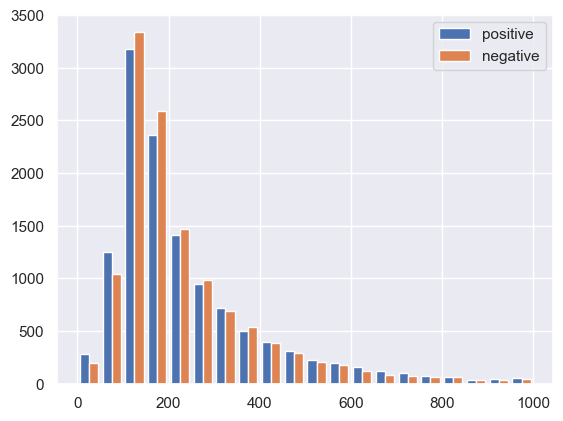

Longest positive review: 2494
Longest negative review: 1571


In [5]:
# Create a list of lengths for training examples with a positive label.
text_lengths_pos = [len(x) for (i, x) in enumerate(X_train) if Y_train[i]]

# And a list of lengths for training examples with a negative label.
text_lengths_neg = [len(x) for (i, x) in enumerate(X_train) if not Y_train[i]]

# The histogram function can take a list of inputs and corresponding labels.
plt.hist([text_lengths_pos, text_lengths_neg], bins=20, range=(0, 1000),
         label=['positive', 'negative'])
plt.legend()
plt.show()

# Also check the longest reviews.
print('Longest positive review:', max(text_lengths_pos))
print('Longest negative review:', max(text_lengths_neg))

---
### Exercise 1: Token Counts (20 points)
For each of the given tokens, construct a table with the number of positive training examples that include that token and the number of negative training examples that include that token. For reference, here are the counts for the first two tokens:

|Token|Pos Count|Neg Count|
|-|-|-|
|good|4767|4849|
|bad|1491|4396|

In [6]:
tokens = ['good', 'bad', 'amazing', 'boring', 'laugh', 'cry']

# Create a dictionary mapping each token to its id.
token_ids = dict([(token, index[token]) for token in tokens])

In [7]:
def check_tokens_in_review(X_train, Y_train, tokens, token_ids):
    """
    Returns a dataframe with a column for each token and a row for each review.
    The columns for each token is a 1 if the token is present in the review and 0 otherwise.

    Params:
        X_train: A list of reviews.
        Y_train: A list of labels for each review.
        token_ids: A dictionary mapping each token (string format) to its id.

    Returns:
        A dataframe with a column for each token and a row for each review.
    """
    # Create a new dataframe that contains X_train and Y_train
    df = pd.DataFrame(X_train, columns=['review']) ## Convert X_train to a dataframe
    df['label'] = Y_train ## Join Y_train to the dataframe

    # Create columns for each token and set the value to 1 if the token is present in the review.
    for token in tokens:
        df[token] = df['review'].apply(lambda x: 1 if token_ids[token] in x else 0)

    # Delete the review column
    del df['review']

    # Remap the labels to strings
    df['label'] = df['label'].map({0: 'Negative', 1: 'Positive'})

    return df

def count_tokens(df):
    """
    Counts the number of reviews that contain each token for each label (positive and negative)
    
    Params:
        df: A dataframe with a column for each token and a row for each review.

    Returns:
        A dataframe with a column for positive counts, a column for negative counts, and a row for each token
    """
    # Create an empty dataframe to store the results
    df_token_counts = pd.DataFrame()

    # Loop through tokens
    for token in tokens:
        # Add a column with the token name and the number of reviews that contain the token
        df_token_counts[token] = df[df[token] == 1]['label'].value_counts()

    # Pivot the dataframe so that the index is the label and the columns are the tokens
    df_token_counts = df_token_counts.transpose()

    # Reorder the columns
    df_token_counts = df_token_counts[['Positive', 'Negative']]

    # Rename the columns
    df_token_counts.columns = [['Pos count', 'Neg count']]

    return df_token_counts

df_token_counts = count_tokens(check_tokens_in_review(X_train, Y_train, tokens, token_ids))
df_token_counts

,Pos count,Neg count
good,4767,4849
bad,1491,4396
amazing,868,240
boring,301,1205
laugh,525,685
cry,231,114


---

## Feature Representation
Consider the difference between the pixel features we used for image classification and the text features we are now dealing with.

An image had 784 pixel positions. At each position, there is a single value in [0,1] (after normalization).

In contrast, a review has a variable number of ordered tokens (up to 2494 in the training examples). Each token occurs in a particular position. We can think of the token positions much like the 784 pixel positions, except that some of the trailing positions are empty, since review lengths vary.  At each token position, there is a single token, one of the 88587 entries in the vocabulary. So we can think of a review as a (2500, 90000) matrix: At each of ~2500 token positions, we have 1 of ~90000 token ids.

This representation would have 2500 * 90000 = 225 million features -- quite a lot more complexity than the images, though as you'll see below, we will make some simplifying assumptions, reducing both the number of token positions and the number of vocabulary items.

### Padding and Reduced Length
As is clear from the length histogram, the current representation of the review text is a variable-length array. Since fixed-length arrays are easier to work with in Tensorflow, let's add special padding tokens at the end of each review until they are all the same length.

We'll also use this operation to limit the number of token positions by truncating all reviews to a specified length. In the code below, as an example, we pad all training inputs to length 300.

In [8]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

# Pad and truncate to 300 tokens.
X_train_padded = pad_data(X_train, max_length=300)

# Check the padded output.
print('Length of X_train[0]:', len(X_train[0]))
print('Length of X_train_padded[0]:', len(X_train_padded[0]))
print(X_train_padded[0])

Length of X_train[0]: 218
Length of X_train_padded[0]: 300
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670 22665     9    35   480   284     5   150     4   172   112
   167 21631   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4 31050     7  3766
     5   723    36    71    43   530   476    26   400   317    4

### Reduced Vocabulary
We also want to be able to limit the vocabulary size. Since our padding function produces fixed-length sequences in a numpy matrix, we can use clever numpy indexing to efficiently replace all token ids larger than some value with the designated out-of-vocabulary (OOV) id.

In the code below, as an example, we'll keep just token ids less than 1000, replacing all others with OOV.

In [9]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

# Reduce vocabulary to 1000 tokens.
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
print(X_train_reduced[0])

# Decode to see what this looks like in tokens. Note the '#' for OOVs.
print(decode(X_train_reduced[0]))

[  1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173  36 256
   5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4 172 112
 167   2 336 385  39   4 172   2   2  17 546  38  13 447   4 192  50  16
   6 147   2  19  14  22   4   2   2 469   4  22  71  87  12  16  43 530
  38  76  15  13   2   4  22  17 515  17  12  16 626  18   2   5  62 386
  12   8 316   8 106   5   4   2   2  16 480  66   2  33   4 130  12  16
  38 619   5  25 124  51  36 135  48  25   2  33   6  22  12 215  28  77
  52   5  14 407  16  82   2   8   4 107 117   2  15 256   4   2   7   2
   5 723  36  71  43 530 476  26 400 317  46   7   4   2   2  13 104  88
   4 381  15 297  98  32   2  56  26 141   6 194   2  18   4 226  22  21
 134 476  26 480   5 144  30   2  18  51  36  28 224  92  25 104   4 226
  65  16  38   2  88  12  16 283   5  16   2 113 103  32  15  16   2  19
 178  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

### One-hot Encoding
Our current feature representations are **sparse**. That is, we only keep track of the token ids that are present in the input. A **one-hot** encoding replaces a value like 22 (corresponding to 'film') with an array with a single 1 at position 22 and zeros everywhere else. This will be very memory-inefficient, but we'll do it anyway for clarity.

As discussed above, let's dramatically reduce both the number of token positions (review length) and the number of token ids (vocabulary). We'll clip each review after 20 tokens (so 2500 -> 20) and keep only the most common 1000 tokens (so 90000 -> 1000).

In [10]:
# Keras has a util to create one-hot encodings.
X_train_padded = pad_data(X_train, max_length=20)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
print('X_train_reduced shape:', X_train_reduced.shape)
X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
print('X_train_one_hot shape:', X_train_one_hot.shape)

X_train_reduced shape: (25000, 20)
X_train_one_hot shape: (25000, 20, 1000)


Note the shape of the one-hot encoded features. For each of our 25000 training examples, we have a 20 x 1000 matrix. That is, for each of 20 token positions, we have a vector of 1000 elements containing a single 1 and 999 zeros.

We can think of these 1000-dimensional one-hot arrays as **embeddings**. Each token in the input has a 1000-dimensional representation. But because of the one-hot setup, the distance between each pair of tokens is the same ([1,0,0,...], [0,1,0,...], etc.). By contrast, learned embeddings result in meaningful distances between pairs of tokens. We'll get to that soon.

## Logistic Regression with One-Hot Encodings
Let's start with something familiar -- logistic regression. Since our feature representation is in 2 dimensions (20 x 1000), we need to flatten it to pass it to Keras (remember we did this with the pixel data too). Let's try two strategies for flattening.

1. Flatten by *concatenating* (as we did with pixels), turning (20 x 1000) data into (20000,) data. The result is a separate feature for each token at each position.
2. Flatten by *averaging* over token positions, turning (20 x 1000) data into (1000,) data. The result is an array with average token counts, ignoring position.

NOTE: Our prior assignments have used the standard Stochastic Gradient Descent (SGD) optimizer to compute the gradient from an estimate of the loss (based on the current mini-batch). There are many alternative optimizers. Here we'll use the **Adam** optimizer, which sometimes gives better results. One key characteristic of Adam is that it effectively uses a different learning rate for each parameter rather than a fixed learning rate as in SGD.

In [11]:
def build_onehot_model(average_over_positions=False):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer='adam',             # fancy optimizer
                metrics=['accuracy'])

  return model

Now let's try fitting the model to our training data and check performance metrics on the validation (held-out) data. But first, here's a function for plotting the learning curves given the training history object we get from Keras.

In [12]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

Epoch 1/5


2023-07-13 18:42:56.609950: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


352/352 [==============================] - 4s 10ms/step - loss: 0.6789 - accuracy: 0.6108 - val_loss: 0.6649 - val_accuracy: 0.6584
Epoch 2/5
352/352 [==============================] - 3s 8ms/step - loss: 0.6336 - accuracy: 0.7454 - val_loss: 0.6444 - val_accuracy: 0.6744
Epoch 3/5
352/352 [==============================] - 3s 9ms/step - loss: 0.5969 - accuracy: 0.7762 - val_loss: 0.6284 - val_accuracy: 0.6788
Epoch 4/5
352/352 [==============================] - 3s 8ms/step - loss: 0.5668 - accuracy: 0.7978 - val_loss: 0.6173 - val_accuracy: 0.6800
Epoch 5/5
352/352 [==============================] - 3s 9ms/step - loss: 0.5411 - accuracy: 0.8097 - val_loss: 0.6082 - val_accuracy: 0.6844


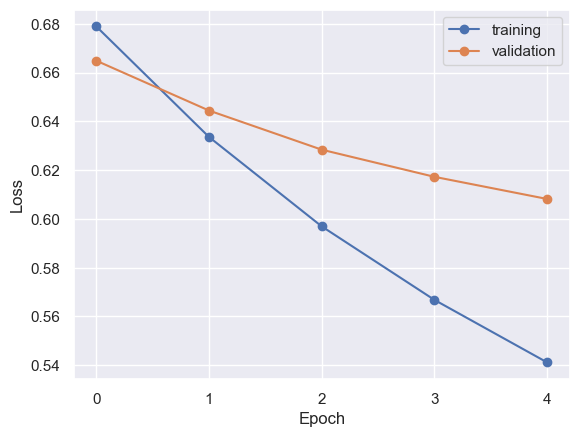

In [13]:
model = build_onehot_model()

# Fit the model.
history = model.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
plot_history(history)

---
### Exercise 2: Comparing logistic regrerssion models (20 points)
Train the one-hot model using both the concatenating and the averaging strategies and compare the results. Let's call these *LR-C* (Logistic Regression Concatenating) and *LR-A* (Logistic Regression Averaging). Then answer the following questions:

1. What are the final training and validation accuracies for LR-C and LR-A?
2. How many parameters are there in each model?
3. Would you say that either model is overfitting? Why or why not?
4. Briefly describe how LR-C differs from LR-A. How do you explain the relationship between their respective validation accuracy results? 

LR-C model
Epoch 1/5
352/352 [==============================] - 3s 9ms/step - loss: 0.6789 - accuracy: 0.6084 - val_loss: 0.6658 - val_accuracy: 0.6524
Epoch 2/5
352/352 [==============================] - 3s 8ms/step - loss: 0.6336 - accuracy: 0.7432 - val_loss: 0.6454 - val_accuracy: 0.6712
Epoch 3/5
352/352 [==============================] - 3s 8ms/step - loss: 0.5970 - accuracy: 0.7746 - val_loss: 0.6292 - val_accuracy: 0.6780
Epoch 4/5
352/352 [==============================] - 3s 8ms/step - loss: 0.5669 - accuracy: 0.7941 - val_loss: 0.6181 - val_accuracy: 0.6784
Epoch 5/5
352/352 [==============================] - 3s 8ms/step - loss: 0.5412 - accuracy: 0.8088 - val_loss: 0.6089 - val_accuracy: 0.6808
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 20000)             0         
                                                                 


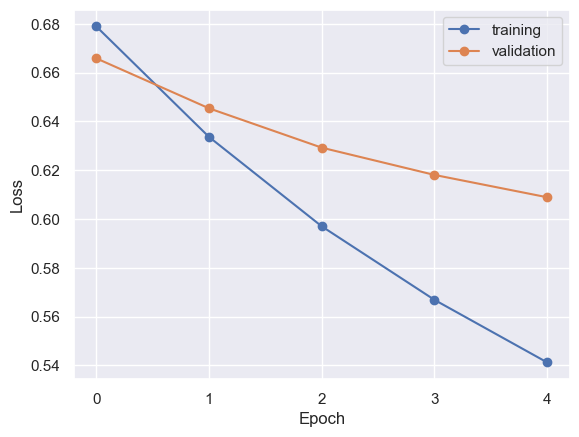

Final training accuracy: 0.8087999820709229
Final validation accuracy: 0.6808000206947327

LR-A model
Epoch 1/5
352/352 [==============================] - 4s 10ms/step - loss: 0.6909 - accuracy: 0.6049 - val_loss: 0.6884 - val_accuracy: 0.6480
Epoch 2/5
352/352 [==============================] - 3s 9ms/step - loss: 0.6857 - accuracy: 0.6768 - val_loss: 0.6838 - val_accuracy: 0.6732
Epoch 3/5
352/352 [==============================] - 3s 9ms/step - loss: 0.6808 - accuracy: 0.6765 - val_loss: 0.6792 - val_accuracy: 0.6888
Epoch 4/5
352/352 [==============================] - 3s 9ms/step - loss: 0.6761 - accuracy: 0.6998 - val_loss: 0.6749 - val_accuracy: 0.6896
Epoch 5/5
352/352 [==============================] - 3s 9ms/step - loss: 0.6715 - accuracy: 0.7005 - val_loss: 0.6709 - val_accuracy: 0.6912
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling1d (G  (None, 100

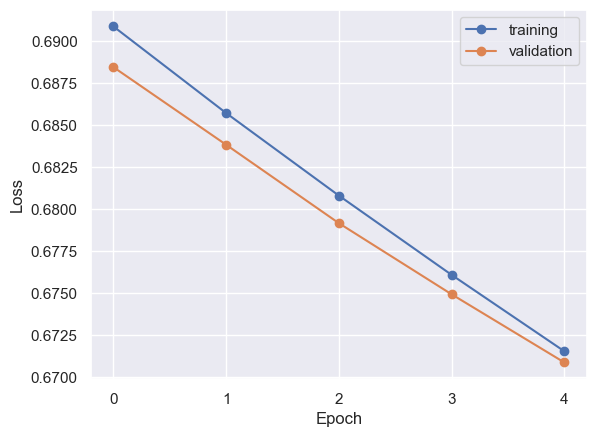

Final training accuracy: 0.7004888653755188
Final validation accuracy: 0.6912000179290771



In [14]:
def log_regression_experiments(average_over_positions):
    """Run logistic regression experiments based on whether average_over_positions is True or False."""
    print("LR-A model") if average_over_positions else print ("LR-C model")

    model = build_onehot_model(average_over_positions=average_over_positions)

    # Fit the model.
    history = model.fit(
    x = X_train_one_hot,  # one-hot training data
    y = Y_train,          # corresponding binary labels
    epochs=5,             # number of passes through the training data
    batch_size=64,        # mini-batch size
    validation_split=0.1, # use a fraction of the examples for validation
    verbose=1             # display some progress output during training
    )

    # Convert the return value into a DataFrame so we can see the train loss 
    # and binary accuracy after every epoch.
    history = pd.DataFrame(history.history)
    
    # Print model summary to list the number of parameters
    print(model.summary())   

    # Plot the training and validation loss
    plot_history(history)
    
    # Print the final training and validation accuracy
    print("Final training accuracy:", history['accuracy'].iloc[-1])
    print("Final validation accuracy:", history['val_accuracy'].iloc[-1])
    print()

log_regression_experiments(average_over_positions=False)
log_regression_experiments(average_over_positions=True)


*Written answers:*

1. The final training and validation accuracies are 0.810 and 0.681, respectively for the LR-C model. The final training and validation accuracies are 0.700 and 0.695, respectively for the LR-A model.
2. The LR-C model has 20,001 parameters (20,000 weights for each row of the input vector + 1 bias term) while the LR-A model has 1,001 parameters (1,000 weights for each row of the input vector + 1 bias term)
3. The LR-C model appears to be overfitting due to a larger gap between training and validation accuracies. The LR-C model has a difference of 0.129 between the training accuracy (0.810) and validation accuracy (0.681). This suggests that the LR-C model is performing much better on the training data compared to the validation data, suggesting that it maybe memorizing the training data and is not generalizing well. In contrast, the LR-A model has a much smaller gap (0.005) between training accuracy (0.700) and validation accuracy (0.695), which suggests that it is less prone to overfitting and is more generalizeable for unseen data.
4. Since LR-C uses a concatenation strategy, the LR-C model maintains the full complexity of the original one-hot encodings, which itself includes noise and redundancy, potentially contributing to it overfitting the training data. In contrast, the LR-A model uses an averaging strategy which "smoothes" out the noise, and simplifies the feature representation, promoting better generalization and performance. This is why the LR-A outperforms the LR-C both in terms of absolute validation accuracy and the variance (difference between training and validation accuracy)


---

## Logistic Regression with Embeddings
Next, let's train model that replaces one-hot representations of each token with learned embeddings.

The code below uses a Keras Embedding layer, which expects to receive a sparse (rather than one-hot) representation. That is, it expects a (padded) sequence of token ids; for each id, it looks up the corresponding embedding vector.

In [15]:
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=20,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])

  return model

Try training the model as before. We'll use the averaging strategy rather than the concatenating strategy for dealing with the token sequence. That is, we'll look up embedding vectors for each token. Then we'll average them to produce a single vector. Then we'll traing a logistic regression with that vector as input to predict the binary label.

Epoch 1/5
352/352 [==============================] - 5s 12ms/step - loss: 0.6878 - accuracy: 0.6385 - val_loss: 0.6805 - val_accuracy: 0.6716
Epoch 2/5
352/352 [==============================] - 4s 13ms/step - loss: 0.6679 - accuracy: 0.6923 - val_loss: 0.6577 - val_accuracy: 0.6928
Epoch 3/5
352/352 [==============================] - 3s 9ms/step - loss: 0.6410 - accuracy: 0.7033 - val_loss: 0.6317 - val_accuracy: 0.7028
Epoch 4/5
352/352 [==============================] - 3s 9ms/step - loss: 0.6138 - accuracy: 0.7148 - val_loss: 0.6092 - val_accuracy: 0.7056
Epoch 5/5
352/352 [==============================] - 3s 9ms/step - loss: 0.5901 - accuracy: 0.7213 - val_loss: 0.5908 - val_accuracy: 0.7116


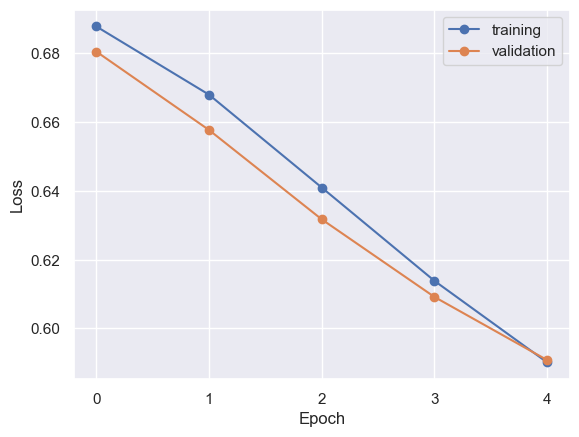

In [16]:
model = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=2)
history = model.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

history = pd.DataFrame(history.history)
plot_history(history)

---
### Exercise 3: Experiments with embeddings (20 points)
Train 6 models with embedding sizes in [2,4,8,16,32,64], keeping other settings fixed. Use the averaging strategy rather than the concatenating strategy.

1. Construct a table with the training and validation accuracies of each model (after 5 training epochs).
2. Compute the number of parameters in each model.
3. Do learned embeddings appear to provide improved performance over the one-hot encoding? Why?

In [17]:
def embedding_experiment(embedding_sizes):
    """Run an experiment to compare accuracies and number of parameters for different embedding sizes."""
    
    # Create a new dataframe to represent a table with the training and validation accuracies of each model (6 different models with embedding sizes in [2,4,8,16,32,64])
    df = pd.DataFrame(columns=['Embedding size', 'Training accuracy', 'Validation accuracy', 'Number of parameters'])
    df['Embedding size'] = embedding_sizes

    # Loop through each embedding size
    for size in embedding_sizes:
        model = build_embeddings_model(average_over_positions=True,
                                vocab_size=1000,
                                sequence_length=20,
                                embedding_dim=size)
        history = model.fit(
        x = X_train_reduced,  # our sparse padded training data
        y = Y_train,          # corresponding binary labels
        epochs=5,             # number of passes through the training data
        batch_size=64,        # mini-batch size
        validation_split=0.1, # use a fraction of the examples for validation
        verbose=0             # display no progress output during training
        )

        history = pd.DataFrame(history.history)
        
        # Add the training and validation accuracy to the dataframe
        df.loc[df['Embedding size'] == size, 'Training accuracy'] = history['accuracy'].iloc[-1]
        df.loc[df['Embedding size'] == size, 'Validation accuracy'] = history['val_accuracy'].iloc[-1]

        # Get the number of parameters
        num_params = model.count_params()
        df.loc[df['Embedding size'] == size, 'Number of parameters'] = num_params

    return df

df_embedding_experiment_summary = embedding_experiment(embedding_sizes=[2,4,8,16,32,64])
df_embedding_experiment_summary

,Embedding size,Training accuracy,Validation accuracy,Number of parameters
0,2,0.721911,0.7144,2003
1,4,0.732089,0.7176,4005
2,8,0.7404,0.7216,8009
3,16,0.748667,0.7276,16017
4,32,0.751822,0.7312,32033
5,64,0.7552,0.7284,64065


*Written answers:*

1. The table with the training and validation accuracies for each experiment are as shown above
2. The number of parameters for each model is listed in the table above
3. Learned embeddings provide improvements in performance over the one-hot encodings. This is shown in the table above, where the training and validation accuracies of the models training using embeddings outperform the equivalent LR-A model trained with one-hot encodings. This is because embeddings are derived from the contextual usage of words, capturing relationships, similarities and differencies between words. By considering how frequently words appear alongside other words in the vocabulary, embeddings encode sematic information, which allows the model to make more informed predictions. In contrast, one-hot encodings do not capture the relationships between different words as the encoding simply captures whether or not a certain word is present, without considering the context of how a word is used. This explains the gap in performance between models trained using embeddings vs. the model trained using one-hot encodings.

---

## Inspecting Learned Embeddings
Let's retrieve the learned embedding parameters from the trained model and plot the token embeddings.

The model layers in a Keras Sequential model are stored as a list and the embeddings are the first layer. We can use the get_weights() function to get a numpy array with the parameters.

In [18]:
# Display the model layers.
display(model.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings = model.layers[0].get_weights()[0]
display(embeddings.shape)

(1000, 2)

Now we'll use a fancy plotting tool called *plotly* to show the embeddings with hovertext so you can move your mouse over the points to see the corresponding tokens.

In [19]:
embeddings

array([[ 0.18621813, -0.15694286],
       [ 0.08085769, -0.11886136],
       [-0.00499473, -0.04948486],
       ...,
       [-0.15708756,  0.13059443],
       [-0.16050626,  0.10933536],
       [-0.35018292,  0.32890257]], dtype=float32)

In [20]:
def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]
  
  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]
  
  # Construct the hover text to show the text, x1 value, and x2 value.
  hover_text = [f'Text: {token}<br>x1: {x1_val:.2f}<br>x2: {x2_val:.2f}' for token, x1_val, x2_val in zip(tokens, x1, x2)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=hover_text,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest',
                                           width=800, height=800))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.    
plot_2d_embeddings(embeddings, id_start=500, count=500)

In [21]:
# Create a dataframe that contains tokens and their corresponding embeddings
def create_embedding_df(embeddings, id_start=1, count=100):
    # Get 1st and 2nd embedding dims for the desired tokens.
    x1 = embeddings[id_start:id_start+count, 0]
    x2 = embeddings[id_start:id_start+count, 1]
    
    # Get the corresponding words from the reverse index (for labeling).
    tokens = [reverse_index[i] for i in range(id_start, id_start+count)]
    
    # Construct the dataframe.
    df = pd.DataFrame({'token': tokens, 'x1': x1, 'x2': x2})
    
    return df

df_embeddings = create_embedding_df(embeddings, id_start=500, count=500)

# Export to csv
df_embeddings.to_csv('df_embeddings.csv', index=False)


---
### Exercise 4: Interpreting Embeddings (20 points)
Notice that the 2-D embeddings fall in a narrow diagonal band.

1. Have the learned embeddings separated positive and negative words? What is the most negative word? Does this make sense?
2. Give 2 examples of words that seem to have surprising embedding values and try to explain their positions. For example, what's going on with the tokens '7', '8', and '9'? What are two other surprising results?
3. The embedding for 'crazy' is very close to (0,0). Explain what this means in terms of the model's output.
4. Can you explain what you think the 2 learned embedding dimensions mean, if anything?

*Written answers:*

1. The embeddings appear to have separated the positive and negative words. Words with higher x1 and lower x2 values (e.g., towards the top left quadrant of the plot) appear to be be negative words, whereas words with lower x1 and lower x2 values (e.g., towards the bottom right quadrant of the plot) appear to be positive words. The most negative word is 'avoid,' which makes sense within the context of drug reviews as it most likely represents a strong recommendation against using a drug.
2. Interestingly, the embedding for 'Save' leans towards the negative side (x1: -0.93, x2: 0.95), despite not inherently sounding negative. Surprisingly, it is located in close proximity to other negative words like 'avoid' and 'crap'. Similarly, 'Chance' (x1: 0.64, x2: -0.66) is considered a positive word in the embedding and is clustered near positive words such as 'brilliant' and 'enjoyable'. At first glance, 'Chance' might appear as a neutral word, but its placement suggests a positive sentiment. These unexpected positions can be attributed to the frequent co-occurrence of 'Save' with other negative words and 'Chance' with positive words. Consequently, the embedding model learns to associate 'Save' with negative sentiment and 'Chance' with positive sentiment based on their consistent usage alongside other words of corresponding sentiment. The same would hold true for tokens '7', '8' and '9' - their position indicates that these tokens frequently co-occur with other words associated with positive sentiment.
3. The embedding for 'crazy' is positioned near the origin (0,0) in the embedding space, indicating a neutral sentiment association. This implies that the sentiment associated with 'crazy' is neither strongly negative nor positive in the model's output. The neutral embedding suggests that the inclusion of 'crazy' in a review does not reliably predict the review's sentiment.
4. The individual interpretation of each embedding dimension is difficult to determine conclusively, but we can make observations about their aggregate representation. The 2-D embeddings show a narrow diagonal band, suggesting that both dimensions capture sentiment polarity (positivity or negativity). Additionally, the proximity of words in terms of their embedding distances reflects similartiy between words. For example, "actor" and "actress" as well as "kill" and "killed" have similar values for both dimensions. In summary, while the exact meaning of each dimension remains unclear, it appears that they represent sentiment polarity and semantic similarities between words.

---

## Scaling Up!
Remember how we limited our input sequences to 20 tokens and 1000 vocabulary entries? Let's see how well we can do using more data and bigger models (more parameters).

### Exercise 5: Improve Results (20 points)
Using pieces of code from above, set up and train a model that improves the validation accuracy to at least 80%. You should include the following elements:

1. Truncate and pad input to the desired length.
2. Limit vocabulary to the desired size.
3. Set up a model using embeddings.
4. Add an additional layer or layers (after the embeddings layer and before the output layer).
5. Evaluate on the test data. Remember to apply the same pre-processing to the test data. You can use model.evaluate().

#### EDA

First, determine what length would capture the reviews

Text(0.5, 1.0, 'Cumulative density of review lengths')

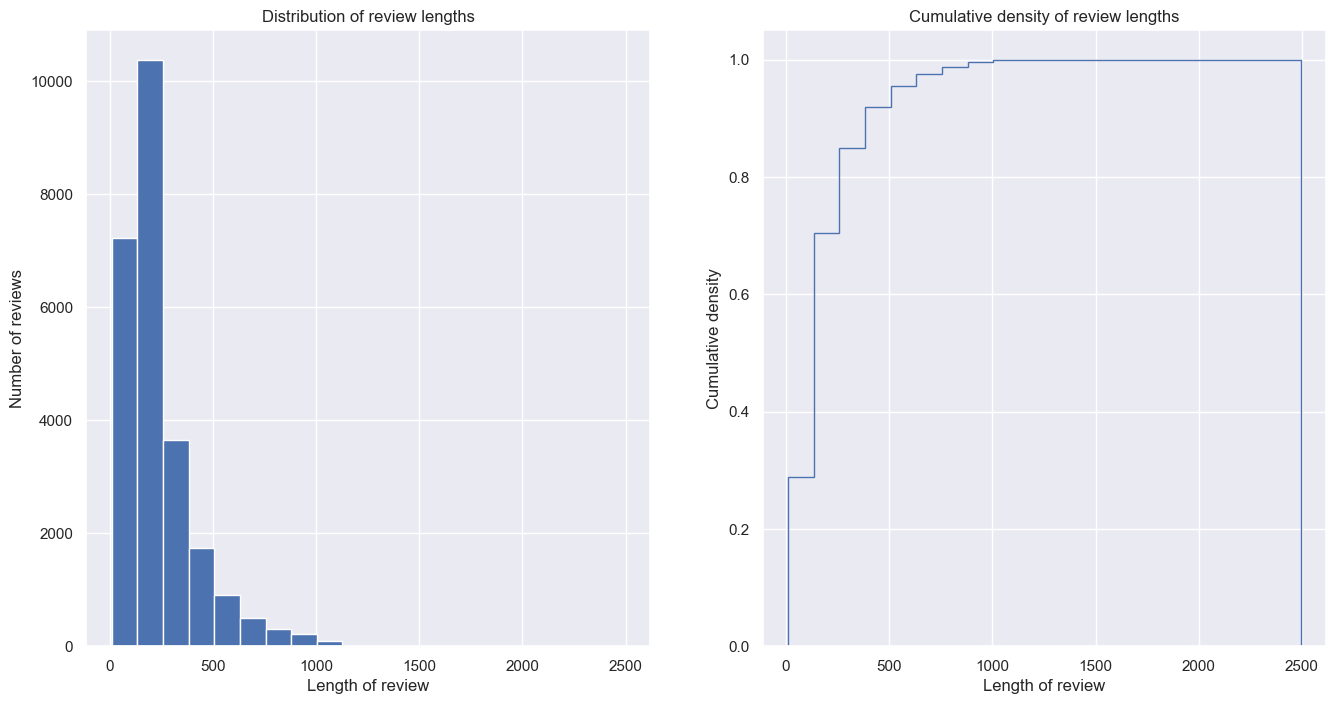

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# On the first axis, plot a histogram of lengths of each row of X_train
ax[0].hist([len(x) for x in X_train], bins=20)
ax[0].set_xlabel('Length of review')
ax[0].set_ylabel('Number of reviews')
ax[0].set_title('Distribution of review lengths')

# On the second axis, plot a cumulative density function of lengths of each row of X_train
ax[1].hist([len(x) for x in X_train], bins=20, cumulative=True, density=True, histtype='step')
ax[1].set_xlabel('Length of review')
ax[1].set_ylabel('Cumulative density')
ax[1].set_title('Cumulative density of review lengths')

In [23]:
# Build embedding model
def build_embeddings_model_2(X_train=X_train,
                             average_over_positions=True,
                             vocab_size=1000,
                             sequence_length=20,
                             embedding_dim=32,
                             hidden_layer_units=16):
    """Build a tf.keras model using embeddings."""

    # Pad data and limit vocab
    X_train_padded = pad_data(X_train, max_length=sequence_length)
    X_train_reduced = limit_vocab(X_train_padded, max_token_id=vocab_size)

    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length)
    )

    if average_over_positions:
        # This layer averages over the first dimension of the input by default.
        model.add(tf.keras.layers.GlobalAveragePooling1D())
    else:
        # Concatenate.
        model.add(tf.keras.layers.Flatten())

    # Add an additional hidden layer with 16 units and ReLU activation
    model.add(tf.keras.layers.Dense(
        units=hidden_layer_units,
        activation='relu'
    ))

    # Output layer
    model.add(tf.keras.layers.Dense(
        units=1,
        activation='sigmoid'
    ))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


#### Run experiments to tune vocab_size and sequence_length hyperparameters

In [49]:
# Setup code to run experiments
def final_experiment(input_df, vocab_size, sequence_length):
    print(f"Running experiment with vocab size {vocab_size} and sequence length {sequence_length}")

    # Create a temporary dataframe to store the results of the experiment
    temp_df = pd.DataFrame({'Vocab size': [vocab_size], 'Sequence length': [sequence_length]})

    X_train_padded = pad_data(X_train, max_length=sequence_length)
    X_train_reduced = limit_vocab(X_train_padded, max_token_id=vocab_size)

    model = build_embeddings_model_2(X_train=X_train,
                                        average_over_positions=True,
                                        vocab_size=vocab_size,
                                        sequence_length=sequence_length,
                                        embedding_dim=32,
                                        hidden_layer_units=16)

    history = model.fit(x=X_train_reduced,
                        y=Y_train,
                        epochs=5,
                        batch_size=64,
                        validation_split=0.1,
                        verbose=1)

    history = pd.DataFrame(history.history)
    plot_history(history)

    # Add the training and validation accuracy to the temporary dataframe
    temp_df[['Training accuracy', 'Validation accuracy']] = [history['accuracy'].iloc[-1],
                                                                history['val_accuracy'].iloc[-1]]

    # Concatenate the temporary dataframe with the main dataframe
    df = pd.concat([input_df, temp_df], ignore_index=True)

    return df

In [50]:
# Create a dataframe to represent a table with the training and validation accuracies of each model 
df_final_experiment = pd.DataFrame(columns=['Vocab size', 'Sequence length', 'Training accuracy', 'Validation accuracy'])

Running experiment with vocab size 2000 and sequence length 50
Epoch 1/5
352/352 [==============================] - 17s 45ms/step - loss: 0.5828 - accuracy: 0.7086 - val_loss: 0.4622 - val_accuracy: 0.7852
Epoch 2/5
352/352 [==============================] - 8s 24ms/step - loss: 0.4172 - accuracy: 0.8109 - val_loss: 0.4320 - val_accuracy: 0.7976
Epoch 3/5
352/352 [==============================] - 8s 22ms/step - loss: 0.3918 - accuracy: 0.8239 - val_loss: 0.4243 - val_accuracy: 0.8048
Epoch 4/5
352/352 [==============================] - 7s 19ms/step - loss: 0.3817 - accuracy: 0.8293 - val_loss: 0.4264 - val_accuracy: 0.8036
Epoch 5/5
352/352 [==============================] - 6s 17ms/step - loss: 0.3782 - accuracy: 0.8324 - val_loss: 0.4299 - val_accuracy: 0.8020


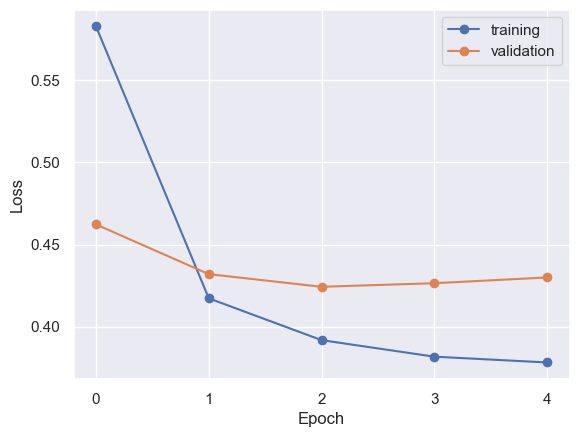

In [51]:
# Run an experiment with vocab_size = 2000 and sequence_length = 50
df_final_experiment = final_experiment(df_final_experiment, vocab_size=2000, sequence_length=50)

Running experiment with vocab size 4000 and sequence length 50
Epoch 1/5
352/352 [==============================] - 20s 52ms/step - loss: 0.5753 - accuracy: 0.7292 - val_loss: 0.4474 - val_accuracy: 0.7988
Epoch 2/5
352/352 [==============================] - 11s 32ms/step - loss: 0.3918 - accuracy: 0.8273 - val_loss: 0.4116 - val_accuracy: 0.8100
Epoch 3/5
352/352 [==============================] - 10s 28ms/step - loss: 0.3534 - accuracy: 0.8456 - val_loss: 0.4092 - val_accuracy: 0.8144
Epoch 4/5
352/352 [==============================] - 9s 25ms/step - loss: 0.3352 - accuracy: 0.8542 - val_loss: 0.4171 - val_accuracy: 0.8088
Epoch 5/5
352/352 [==============================] - 8s 24ms/step - loss: 0.3257 - accuracy: 0.8608 - val_loss: 0.4262 - val_accuracy: 0.8068


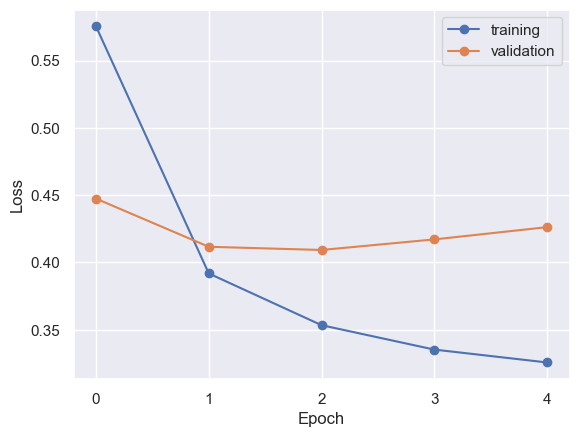

In [52]:
# Run an experiment with vocab_size = 4000 and sequence_length = 50
df_final_experiment = final_experiment(df_final_experiment, vocab_size=4000, sequence_length=50)

Running experiment with vocab size 8000 and sequence length 50
Epoch 1/5
352/352 [==============================] - 28s 74ms/step - loss: 0.5779 - accuracy: 0.7331 - val_loss: 0.4421 - val_accuracy: 0.8036
Epoch 2/5
352/352 [==============================] - 14s 39ms/step - loss: 0.3747 - accuracy: 0.8366 - val_loss: 0.4000 - val_accuracy: 0.8148
Epoch 3/5
352/352 [==============================] - 13s 36ms/step - loss: 0.3193 - accuracy: 0.8640 - val_loss: 0.4002 - val_accuracy: 0.8188
Epoch 4/5
352/352 [==============================] - 11s 32ms/step - loss: 0.2879 - accuracy: 0.8796 - val_loss: 0.4160 - val_accuracy: 0.8180
Epoch 5/5
352/352 [==============================] - 10s 29ms/step - loss: 0.2670 - accuracy: 0.8935 - val_loss: 0.4393 - val_accuracy: 0.8120


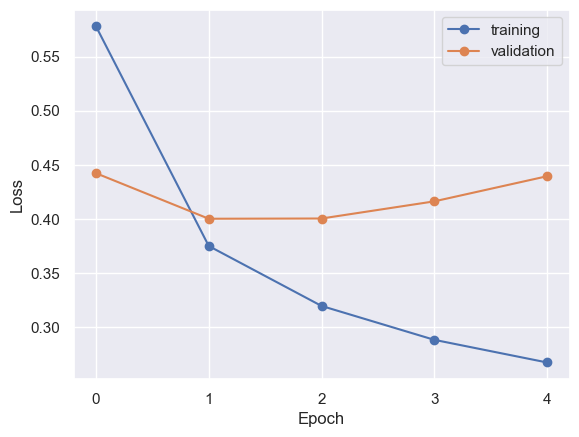

In [53]:
# Run an experiment with vocab_size = 8000 and sequence_length = 50
df_final_experiment = final_experiment(df_final_experiment, vocab_size=8000, sequence_length=50)

From the above it seems like vocab size beyond 2000 leads to overfitting (large variance). Let's set it at 2000 for the time being and experiment with different sequence lengths.

Running experiment with vocab size 2000 and sequence length 100
Epoch 1/5
352/352 [==============================] - 28s 74ms/step - loss: 0.5705 - accuracy: 0.7346 - val_loss: 0.4189 - val_accuracy: 0.8144
Epoch 2/5
352/352 [==============================] - 13s 36ms/step - loss: 0.3662 - accuracy: 0.8394 - val_loss: 0.3795 - val_accuracy: 0.8300
Epoch 3/5
352/352 [==============================] - 12s 33ms/step - loss: 0.3319 - accuracy: 0.8575 - val_loss: 0.3681 - val_accuracy: 0.8344
Epoch 4/5
352/352 [==============================] - 11s 30ms/step - loss: 0.3184 - accuracy: 0.8633 - val_loss: 0.3712 - val_accuracy: 0.8352
Epoch 5/5
352/352 [==============================] - 11s 32ms/step - loss: 0.3121 - accuracy: 0.8672 - val_loss: 0.3704 - val_accuracy: 0.8380


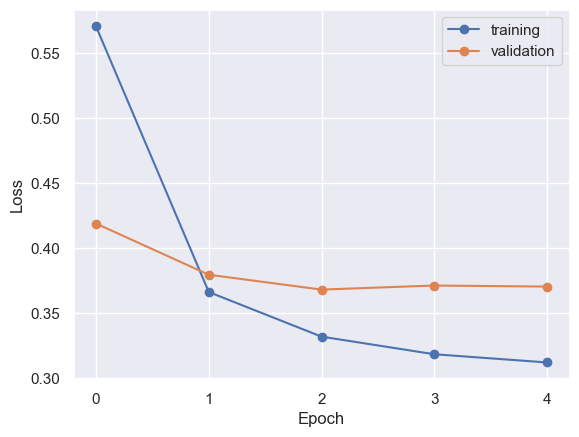

In [54]:
# Run an experiment with vocab_size = 2000 and sequence_length = 100
df_final_experiment = final_experiment(df_final_experiment, vocab_size=2000, sequence_length=100)

Running experiment with vocab size 2000 and sequence length 200


Epoch 1/5
352/352 [==============================] - 31s 82ms/step - loss: 0.5917 - accuracy: 0.7022 - val_loss: 0.4238 - val_accuracy: 0.8388
Epoch 2/5
352/352 [==============================] - 16s 47ms/step - loss: 0.3500 - accuracy: 0.8586 - val_loss: 0.3409 - val_accuracy: 0.8612
Epoch 3/5
352/352 [==============================] - 13s 36ms/step - loss: 0.2985 - accuracy: 0.8768 - val_loss: 0.3333 - val_accuracy: 0.8624
Epoch 4/5
352/352 [==============================] - 14s 40ms/step - loss: 0.2802 - accuracy: 0.8860 - val_loss: 0.3294 - val_accuracy: 0.8684
Epoch 5/5
352/352 [==============================] - 16s 44ms/step - loss: 0.2704 - accuracy: 0.8900 - val_loss: 0.3272 - val_accuracy: 0.8724


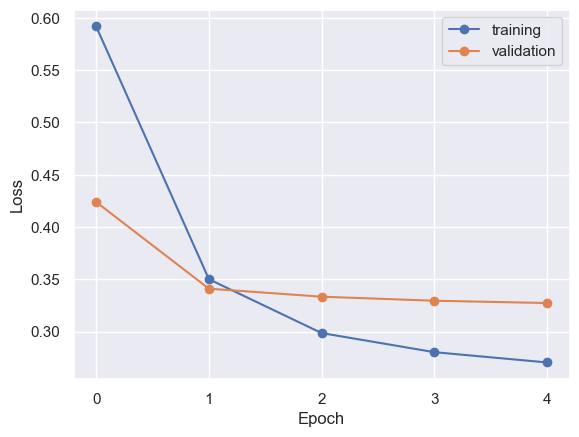

In [55]:
# Run an experiment with vocab_size = 2000 and sequence_length = 200
df_final_experiment = final_experiment(df_final_experiment, vocab_size=2000, sequence_length=200)

Running experiment with vocab size 2000 and sequence length 300
Epoch 1/5
352/352 [==============================] - 46s 123ms/step - loss: 0.6228 - accuracy: 0.7032 - val_loss: 0.4740 - val_accuracy: 0.8276
Epoch 2/5
352/352 [==============================] - 44s 124ms/step - loss: 0.3791 - accuracy: 0.8519 - val_loss: 0.3471 - val_accuracy: 0.8604
Epoch 3/5
352/352 [==============================] - 29s 82ms/step - loss: 0.3086 - accuracy: 0.8747 - val_loss: 0.3313 - val_accuracy: 0.8672
Epoch 4/5
352/352 [==============================] - 30s 84ms/step - loss: 0.2842 - accuracy: 0.8856 - val_loss: 0.3202 - val_accuracy: 0.8720
Epoch 5/5
352/352 [==============================] - 27s 75ms/step - loss: 0.2703 - accuracy: 0.8914 - val_loss: 0.3131 - val_accuracy: 0.8760


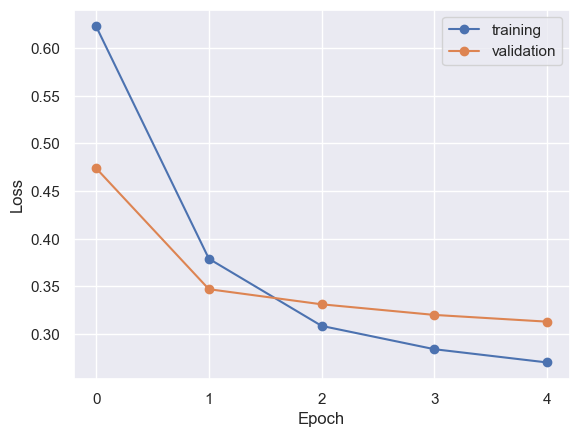

In [56]:
# Run an experiment with vocab_size = 2000 and sequence_length = 300
df_final_experiment = final_experiment(df_final_experiment, vocab_size=2000, sequence_length=300)

In [57]:
df_final_experiment

,Vocab size,Sequence length,Training accuracy,Validation accuracy
0,2000,50,0.832444,0.8020
1,4000,50,0.860844,0.8068
2,8000,50,0.893467,0.8120
3,2000,100,0.867156,0.8380
4,2000,200,0.890044,0.8724
5,2000,300,0.891378,0.8760


#### Fit the test with the chosen hyperparameters and get final accuracy

From the above experiments it seems like a vocab size of 2000 and sequence length of 300 leads to the best validation accuracy. We can use these parameters to fit the test data. 2 epochs also seems like a good point to stop training to avoid overfitting.

In [59]:
# Chosen parameters
sequence_length = 300
vocab_size = 2000

# Preprocess the train data
X_train_padded_final = pad_data(X_train, max_length=sequence_length)
X_train_reduced_final = limit_vocab(X_train_padded, max_token_id=vocab_size)

# Preprocess the test data
X_test_padded_final = pad_data(X_test, max_length=sequence_length)
X_test_reduced_final = limit_vocab(X_test_padded, max_token_id=vocab_size)

# Build the final model with the chosen parameters
final_model = build_embeddings_model_2(X_train=X_train_reduced_final,
                                 average_over_positions=True,
                                 vocab_size=vocab_size,
                                 sequence_length=sequence_length,
                                 embedding_dim=32,
                                 hidden_layer_units=16)

# Change the number of epochs to 2 (since going beyond 2 epochs will result in overfitting)
final_model.fit(X_train_reduced_final, Y_train, epochs=2, batch_size=64, verbose=1)

# Evaluate the model on the test data
test_accuracy = final_model.evaluate(x=X_test_reduced_final, y=Y_test, verbose=1)

# Print the test accuracy
print(f"Test accuracy: {test_accuracy[1]}")

Epoch 1/2
391/391 [==============================] - 59s 143ms/step - loss: 0.5967 - accuracy: 0.7039
Epoch 2/2
782/782 [==============================] - 6s 7ms/step - loss: 0.3262 - accuracy: 0.8660
Test accuracy: 0.8659600019454956
